In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel

/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('csv',data_files='dataset_sentenceattribution_nerfeatures_split.csv',delimiter=',',column_names=["claim","premise","label","category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat","counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat","url", "entities","entity_map","gem_exp","gem_label","gpt_label","gpt_exp","gold_exp","entity_map_ev","entity_ev","synonym","voice","split"],skiprows=1)

Using custom data configuration default-cfbf7584a6bb7c13
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 207.87it/s]


In [3]:
train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-aa1fd4d2889f655e.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-9cd628f4430f2ace.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-df968f39da4ad12a.arrow


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 'gem_exp', 'gem_label', 'gpt_label', 'gpt_exp', 'gold_exp', 'entity_map_ev', 'entity_ev', 'synonym', 'voice', 'split'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_tre

In [5]:
columns_to_keep = ["claim", "premise", "label","category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat","counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat"]
all_columns = dataset["train"].column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [6]:
dataset['train']['label']

['NOT ENOUGH INFORMATION',
 'NOT ENOUGH INFORMATION',
 'NOT ENOUGH INFORMATION',
 'SUPPORTED',
 'NOT ENOUGH INFORMATION',
 'REFUTED',
 'SUPPORTED',
 'SUPPORTED',
 'SUPPORTED',
 'SUPPORTED',
 'SUPPORTED',
 'SUPPORTED',
 'SUPPORTED',
 'SUPPORTED',
 'NOT ENOUGH INFORMATION',
 'SUPPORTED',
 'NOT ENOUGH INFORMATION',
 'SUPPORTED',
 'SUPPORTED',
 'NOT ENOUGH INFORMATION',
 'SUPPORTED',
 'SUPPORTED',
 'SUPPORTED',
 'SUPPORTED',
 'SUPPORTED',
 'REFUTED',
 'SUPPORTED',
 'REFUTED',
 'NOT ENOUGH INFORMATION',
 'NOT ENOUGH INFORMATION',
 'NOT ENOUGH INFORMATION',
 'SUPPORTED',
 'NOT ENOUGH INFORMATION',
 'SUPPORTED',
 'REFUTED',
 'NOT ENOUGH INFORMATION',
 'NOT ENOUGH INFORMATION',
 'SUPPORTED',
 'NOT ENOUGH INFORMATION',
 'REFUTED',
 'SUPPORTED',
 'NOT ENOUGH INFORMATION',
 'SUPPORTED',
 'SUPPORTED',
 'NOT ENOUGH INFORMATION',
 'SUPPORTED',
 'SUPPORTED',
 'NOT ENOUGH INFORMATION',
 'SUPPORTED',
 'NOT ENOUGH INFORMATION',
 'SUPPORTED',
 'SUPPORTED',
 'SUPPORTED',
 'SUPPORTED',
 'NOT ENOUGH INFORMA

In [7]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)

# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-3939f688401dfd1d.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-6e3e675e2ac00106.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-cfbf7584a6bb7c13/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-ec7578b7af56fb7d.arrow


Label Encoding Mapping: {'contradiction': 2, 'entailment': 0, 'neutral': 1}


In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat'],
        num_rows: 465
    })
    test: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 

In [9]:
labels = np.array(dataset['train']['label'])

In [10]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts
        claim = item['claim'] 
        evidences = item['premise']
        item['premise']=evidences
        item['claim']=claim
        additional_features = [
            "counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat"]
    
        for feature in additional_features:
            if feature in item:
                evidences += "[SEP]" + str(item[feature])
        # Tokenize the texts
        inputs = self.tokenizer(
            evidences, claim,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
         # Construct the output item
        output_item = {
            'input_ids': inputs['input_ids'].squeeze(),  # Remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(),  # Remove batch dimension
            'claim': claim,  # Include augmented claim text
            'evidences': evidences  # Include original evidence text
        }
        
        if 'label' in item:
            output_item['label'] = torch.tensor(item['label'], dtype=torch.long)
        
        return output_item



In [11]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [12]:
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=3, ignore_mismatched_sizes=True)
device = "cuda:0"
model.to(device)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
 

In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1}

In [14]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat'],
    num_rows: 1623
})

In [15]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()

In [16]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [17]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [18]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [19]:
tdata.__getitem__(0)

{'input_ids': tensor([    1,  4081,   261,  5042,   333, 73325,  1452,  2155,  6116,  1938,
           272,   262, 88609,   263, 98237,  1830,  1080,  7355,   387,  2655,
           262, 12682,   265, 65008,   292,  1158, 53245,   264, 75840,   293,
          2376,  1158,  1452,  2155,   260,     2,   767,     2,   767,     2,
           767,     2,   767,     2,   767,     2,   767,     2,   767,     2,
           767,     2,   767,     2,   767,     2,   767,     2,   767,     2,
           573, 52341,  1830,  1080,   269,  1359,   427,   267, 17847,   633,
           264,   408,  1300,   262,  2658,   265,   262,  1158,   260,     2,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [20]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


training_args = TrainingArguments(
    output_dir=f'/home/elson/2.1.4_deberta/',
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.6,
    weight_decay=0.1,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)

# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/2.1.4_deberta/best_model')
tokenizer.save_pretrained(f'/home/elson/2.1.4_deberta/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 765


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.685700,0.771715,0.696774,0.675613,0.696774,0.671633
2,0.640200,0.781535,0.668817,0.670648,0.668817,0.669685
3,0.442700,0.821288,0.679570,0.668928,0.679570,0.672811
4,0.357000,0.972683,0.681720,0.667288,0.681720,0.672631
5,0.323900,1.057383,0.662366,0.678758,0.662366,0.668708
6,0.226500,1.137056,0.677419,0.678971,0.677419,0.678100
7,0.184700,1.369506,0.664516,0.681407,0.664516,0.670928
8,0.164200,1.289143,0.643011,0.663450,0.643011,0.650244
9,0.192800,1.409190,0.645161,0.699524,0.645161,0.656677
10,0.109000,1.569958,0.673118,0.677233,0.673118,0.672354


***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/2.1.4_deberta/checkpoint-51
Configuration saved in /home/elson/2.1.4_deberta/checkpoint-51/config.json
Model weights saved in /home/elson/2.1.4_deberta/checkpoint-51/pytorch_model.bin
Deleting older checkpoint [/home/elson/2.1.4_deberta/checkpoint-765] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/2.1.4_deberta/checkpoint-102
Configuration saved in /home/elson/2.1.4_deberta/checkpoint-102/config.json
Model weights saved in /home/elson/2.1.4_deberta/checkpoint-102/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/2.1.4_deberta/checkpoint-153
Configuration saved in /home/elson/2.1.4_deberta/checkpoint-153/config.json
Model weights saved in /home/elson/2.1.4_deberta/checkpoint-153/pytorch_model.bin
Deleting older ch

Configuration saved in /home/elson/2.1.4_deberta/best_model/config.json
Model weights saved in /home/elson/2.1.4_deberta/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/2.1.4_deberta/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/2.1.4_deberta/best_model/special_tokens_map.json
added tokens file saved in /home/elson/2.1.4_deberta/best_model/added_tokens.json


('/home/elson/2.1.4_deberta/best_model/tokenizer_config.json',
 '/home/elson/2.1.4_deberta/best_model/special_tokens_map.json',
 '/home/elson/2.1.4_deberta/best_model/spm.model',
 '/home/elson/2.1.4_deberta/best_model/added_tokens.json')

In [21]:
model_path = "/home/elson/2.1.4_deberta/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/2.1.4_deberta/best_model/config.json
Model config DebertaV2Config {
  "_name_or_path": "/home/elson/2.1.4_deberta/best_model/",
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,

In [22]:
print(test_results)

PredictionOutput(predictions=array([[-1.561  ,  6.28   , -4.957  ],
       [ 4.58   ,  0.3904 , -5.145  ],
       [ 6.305  , -2.354  , -3.844  ],
       [-2.064  ,  4.258  , -2.334  ],
       [ 6.523  , -3.07   , -3.365  ],
       [ 7.246  , -2.92   , -4.137  ],
       [ 5.793  , -1.911  , -3.783  ],
       [ 7.28   , -3.205  , -3.928  ],
       [ 7.207  , -2.77   , -4.234  ],
       [-2.588  ,  4.266  , -1.403  ],
       [ 3.547  , -1.031  , -2.531  ],
       [ 7.277  , -3.213  , -3.87   ],
       [ 5.29   , -1.614  , -3.63   ],
       [ 7.312  , -3.338  , -3.812  ],
       [-2.66   ,  4.965  , -2.307  ],
       [-2.277  , -0.3108 ,  2.652  ],
       [-1.61   ,  5.266  , -3.951  ],
       [ 5.633  , -1.46   , -4.074  ],
       [ 7.312  , -3.31   , -3.812  ],
       [ 5.43   , -0.3975 , -5.008  ],
       [-0.3005 ,  4.84   , -4.74   ],
       [ 6.418  , -1.516  , -4.805  ],
       [-1.274  ,  5.84   , -4.78   ],
       [-1.536  ,  3.955  , -2.51   ],
       [-2.246  , -0.05258,  2.676 

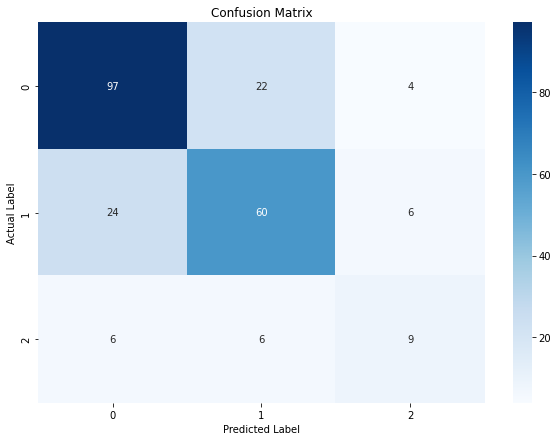

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [24]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/2.1.4_results.csv', index=False)

In [25]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [26]:
correct_classification_counts

General Health           41
Bone health              15
Skin                     15
Fitness                  10
Cancer                   10
Diabetes                  9
Neurological health       8
Throat                    7
Eye                       7
Hair                      6
Cardiovascular Health     6
Ear                       6
Men's health              5
Blood                     5
COVID                     4
Muscles                   4
Women' s Health           4
Mental Health             3
Vascular                  1
Name: Category, dtype: int64

In [27]:
misclassification_counts

General Health           10
Skin                      9
Cardiovascular Health     6
Bone health               6
Hair                      6
Fitness                   5
Blood                     4
Diabetes                  3
Dental Health             3
Eye                       2
COVID                     2
Muscles                   2
Women' s Health           2
Vascular                  2
Cancer                    2
Throat                    2
Men's health              1
Neurological health       1
Name: Category, dtype: int64